In [15]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import statsmodels.api as sm


In [4]:
ticker = 'msft'
start = '2019-5-31'
end = '2022-5-31'

df=yf.download(ticker, start, end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-31 00:00:00-04:00,124.230003,124.620003,123.320000,123.680000,119.434067,26646800
2019-06-03 00:00:00-04:00,123.849998,124.370003,119.010002,119.839996,115.725868,37983600
2019-06-04 00:00:00-04:00,121.279999,123.279999,120.650002,123.160004,118.931915,29382600
2019-06-05 00:00:00-04:00,124.949997,125.870003,124.209999,125.830002,121.510239,24926100
2019-06-06 00:00:00-04:00,126.440002,127.970001,125.599998,127.820000,123.431946,21459000
...,...,...,...,...,...,...
2022-05-23 00:00:00-04:00,255.490005,261.500000,253.429993,260.649994,259.366974,33175400
2022-05-24 00:00:00-04:00,257.890015,261.329987,253.500000,259.619995,258.342041,29043900
2022-05-25 00:00:00-04:00,258.140015,264.579987,257.130005,262.519989,261.227753,28547900


(array([18017.16666667, 18140.16666667, 18262.20833333, 18383.16666667,
        18506.16666667, 18628.20833333, 18748.16666667, 18871.16666667,
        18993.20833333, 19113.16666667]),
 [Text(18017.166666666668, 0, '2019-05'),
  Text(18140.166666666668, 0, '2019-09'),
  Text(18262.208333333332, 0, '2020-01'),
  Text(18383.166666666668, 0, '2020-05'),
  Text(18506.166666666668, 0, '2020-09'),
  Text(18628.208333333332, 0, '2021-01'),
  Text(18748.166666666668, 0, '2021-05'),
  Text(18871.166666666668, 0, '2021-09'),
  Text(18993.208333333332, 0, '2022-01'),
  Text(19113.166666666668, 0, '2022-05')])

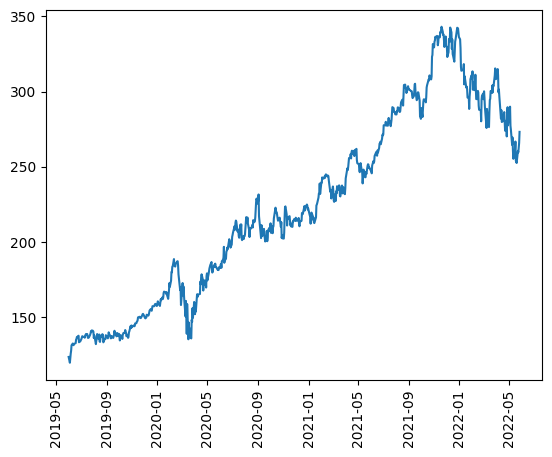

In [12]:
plt.plot(df['Close'])
plt.xticks(rotation=90)

In [18]:
missing_vals = sum(np.isnan(df['Close']))
missing_vals

0

In [23]:
adf_test= sm.tsa.stattools.adfuller(df['Close'])
adf_test
print('p-value is',adf_test[1])

p-value is 0.6239396061100169


/Users/danielbussell/opt/anaconda3/envs/amd_gpu/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


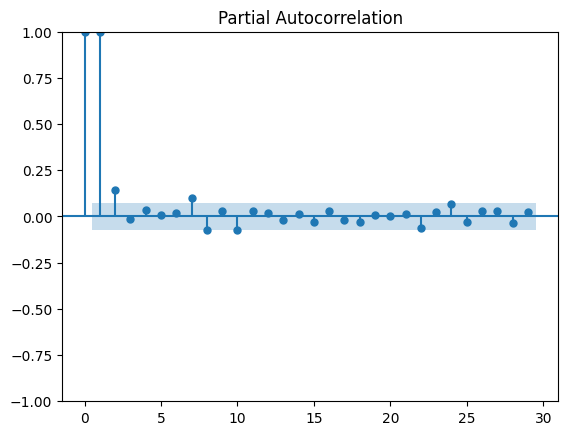

In [24]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pacf=plot_pacf(df['Close'])

In [25]:
n_steps = 2
features = ['Close']
target = ['Close']


In [27]:
weight = 0.8
split =int(weight*len(df))
df_train= df[features].iloc[:split]
df_test= df[features].iloc[split:]

In [29]:
mu=np.float(df_train.mean())
sigma=np.float(df_train.std())
standardise=lambda x: (x-mu)/sigma
df_train=df_train.apply(standardise)

/var/folders/ny/8tmjfmq51yq71k_19n708tfw0000gn/T/ipykernel_36541/3210593343.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mu=np.float(df_train.mean())
/var/folders/ny/8tmjfmq51yq71k_19n708tfw0000gn/T/ipykernel_36541/3210593343.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigma=np.float(df_train.std())


In [30]:
df_test=df_test.apply(standardise)

In [31]:
import keras
import keras.initializers
from keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
from keras.models import Sequential
from keras.models import load_model
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping

In [32]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [42]:
x_train = get_lagged_features(df_train, n_steps, 2)
y_train =  df_train.values[n_steps + 2 - 1:]
y_train_timestamps = df_train.index[n_steps + 2 - 1:]

x_test = get_lagged_features(df_test, n_steps, 2)
y_test =  df_test.values[n_steps + 2 - 1:]
y_test_timestamps = df_test.index[n_steps + 2 - 1:]

In [43]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(601, 2, 1), (601, 1), (149, 2, 1), (149, 1)]


In [44]:
def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [46]:
model_1=GRU_(10,0,0)
batch_size=1000
epochs=1000
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)
model_1.fit(x_train,y_train,epochs=epochs,batch_size=batch_size, callbacks=[es],shuffle=False)

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 2.4205
Epoch 2/1000
1/1 [==============================] - 0s 12ms/step - loss: 2.3929
Epoch 3/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.3655
Epoch 4/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.3383
Epoch 5/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.3114
Epoch 6/1000
1/1 [==============================] - 0s 22ms/step - loss: 2.2846
Epoch 7/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.2581
Epoch 8/1000
1/1 [==============================] - 0s 24ms/step - loss: 2.2318
Epoch 9/1000
1/1 [==============================] - 0s 21ms/step - loss: 2.2057
Epoch 10/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.1799
Epoch 11/1000
1/1 [==============================] - 0s 20ms/step - loss: 2.1542
Epoch 12/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.1287
Epoch 13/1000
1/1 [====================

1/1 [==============================] - 0s 11ms/step - loss: 0.5691
Epoch 103/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.5590
Epoch 104/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.5491
Epoch 105/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.5393
Epoch 106/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.5297
Epoch 107/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.5202
Epoch 108/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.5108
Epoch 109/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.5016
Epoch 110/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.4925
Epoch 111/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.4836
Epoch 112/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.4748
Epoch 113/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.4661
Epoch 114/1000
1/1 [=============

1/1 [==============================] - 0s 12ms/step - loss: 0.1015
Epoch 203/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.1002
Epoch 204/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0989
Epoch 205/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0976
Epoch 206/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0964
Epoch 207/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0952
Epoch 208/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0940
Epoch 209/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0929
Epoch 210/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0917
Epoch 211/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0906
Epoch 212/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0896
Epoch 213/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0885
Epoch 214/1000
1/1 [=============

1/1 [==============================] - 0s 11ms/step - loss: 0.0496
Epoch 303/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0494
Epoch 304/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0493
Epoch 305/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0491
Epoch 306/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0490
Epoch 307/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0488
Epoch 308/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0487
Epoch 309/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0485
Epoch 310/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0484
Epoch 311/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0483
Epoch 312/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0481
Epoch 313/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0480
Epoch 314/1000
1/1 [================

1/1 [==============================] - 0s 12ms/step - loss: 0.0392
Epoch 403/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0392
Epoch 404/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0391
Epoch 405/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0390
Epoch 406/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0389
Epoch 407/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0388
Epoch 408/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0388
Epoch 409/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0387
Epoch 410/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0386
Epoch 411/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0385
Epoch 412/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0384
Epoch 413/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0383
Epoch 414/1000
1/1 [===========

1/1 [==============================] - 0s 10ms/step - loss: 0.0319
Epoch 503/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0318
Epoch 504/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0317
Epoch 505/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0317
Epoch 506/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0316
Epoch 507/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0315
Epoch 508/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0315
Epoch 509/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0314
Epoch 510/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0314
Epoch 511/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0313
Epoch 512/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0312
Epoch 513/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0312
Epoch 514/1000
1/1 [==============

1/1 [==============================] - 0s 9ms/step - loss: 0.0261
Epoch 603/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0260
Epoch 604/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0260
Epoch 605/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0259
Epoch 606/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0259
Epoch 607/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0258
Epoch 608/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0258
Epoch 609/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0257
Epoch 610/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0257
Epoch 611/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0256
Epoch 612/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0256
Epoch 613/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0255
Epoch 614/1000
1/1 [============

1/1 [==============================] - 0s 11ms/step - loss: 0.0217
Epoch 703/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0217
Epoch 704/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0216
Epoch 705/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0216
Epoch 706/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0216
Epoch 707/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0215
Epoch 708/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0215
Epoch 709/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0214
Epoch 710/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0214
Epoch 711/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0214
Epoch 712/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0213
Epoch 713/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0213
Epoch 714/1000
1/1 [=============

1/1 [==============================] - 0s 13ms/step - loss: 0.0185
Epoch 803/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0184
Epoch 804/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0184
Epoch 805/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0184
Epoch 806/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0184
Epoch 807/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0183
Epoch 808/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0183
Epoch 809/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0183
Epoch 810/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0183
Epoch 811/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0182
Epoch 812/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0182
Epoch 813/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0182
Epoch 814/1000
1/1 [============

1/1 [==============================] - 0s 14ms/step - loss: 0.0162
Epoch 903/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0161
Epoch 904/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0161
Epoch 905/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0161
Epoch 906/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0161
Epoch 907/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0161
Epoch 908/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0160
Epoch 909/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0160
Epoch 910/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0160
Epoch 911/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0160
Epoch 912/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0160
Epoch 913/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0159
Epoch 914/1000
1/1 [===========

In [47]:
y_pred=model_1.predict(x_test)

5/5 [==============================] - 0s 1ms/step


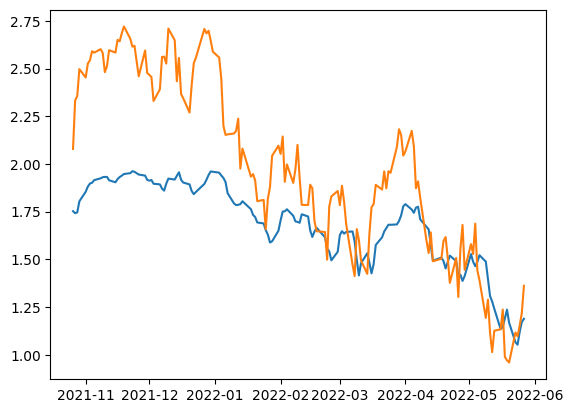

In [53]:
x_vals=y_test_timestamps
y_vals=y_pred
plt.plot(x_vals,y_vals)
plt.plot(x_vals,y_test)

In [54]:
model_2=LSTM_(10,0,0)
batch_size=1000
epochs=1000
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)
model_2.fit(x_train,y_train,epochs=epochs,batch_size=batch_size, callbacks=[es],shuffle=False)

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 1.7862
Epoch 2/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.7764
Epoch 3/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.7666
Epoch 4/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.7569
Epoch 5/1000
1/1 [==============================] - 0s 18ms/step - loss: 1.7472
Epoch 6/1000
1/1 [==============================] - 0s 24ms/step - loss: 1.7375
Epoch 7/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.7278
Epoch 8/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.7181
Epoch 9/1000
1/1 [==============================] - 0s 15ms/step - loss: 1.7085
Epoch 10/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.6988
Epoch 11/1000
1/1 [==============================] - 0s 12ms/step - loss: 1.6892
Epoch 12/1000
1/1 [==============================] - 0s 12ms/step - loss: 1.6796
Epoch 13/1000
1/1 [====================

1/1 [==============================] - 0s 6ms/step - loss: 0.7986
Epoch 104/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.7888
Epoch 105/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.7790
Epoch 106/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7691
Epoch 107/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.7594
Epoch 108/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7496
Epoch 109/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.7398
Epoch 110/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7301
Epoch 111/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.7205
Epoch 112/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.7108
Epoch 113/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.7012
Epoch 114/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.6916
Epoch 115/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 0.1286
Epoch 205/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1259
Epoch 206/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1233
Epoch 207/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1208
Epoch 208/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1183
Epoch 209/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1159
Epoch 210/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1135
Epoch 211/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1112
Epoch 212/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1089
Epoch 213/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.1067
Epoch 214/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1045
Epoch 215/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1024
Epoch 216/1000
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 306/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 307/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0247
Epoch 308/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0245
Epoch 309/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0243
Epoch 310/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0241
Epoch 311/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0239
Epoch 312/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0237
Epoch 313/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0235
Epoch 314/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0234
Epoch 315/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0232
Epoch 316/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0230
Epoch 317/1000
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 0.0180
Epoch 407/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0180
Epoch 408/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0180
Epoch 409/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0179
Epoch 410/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0179
Epoch 411/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0179
Epoch 412/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0179
Epoch 413/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0179
Epoch 414/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0179
Epoch 415/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0179
Epoch 416/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0179
Epoch 417/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0178
Epoch 418/1000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 508/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0172
Epoch 509/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0172
Epoch 510/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0172
Epoch 511/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 512/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 513/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 514/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0171
Epoch 515/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 516/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0171
Epoch 517/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 518/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 519/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 609/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0165
Epoch 610/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 611/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 612/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 613/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 614/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 615/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0165
Epoch 616/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 617/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 618/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0165
Epoch 619/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 620/1000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 710/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 711/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 712/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 713/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0159
Epoch 714/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 715/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0159
Epoch 716/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0159
Epoch 717/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0159
Epoch 718/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 719/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 720/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 721/1000
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 0.0153
Epoch 811/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 812/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0153
Epoch 813/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0153
Epoch 814/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0153
Epoch 815/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0153
Epoch 816/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0153
Epoch 817/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0153
Epoch 818/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0153
Epoch 819/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0153
Epoch 820/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0153
Epoch 821/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 822/1000
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 0.0147
Epoch 912/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0147
Epoch 913/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 914/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 915/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 916/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 917/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 918/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 919/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 920/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 921/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 922/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 923/1000
1/1 [=======================

In [55]:
LSTM_pred=model_2.predict(x_test)

5/5 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Time Series')

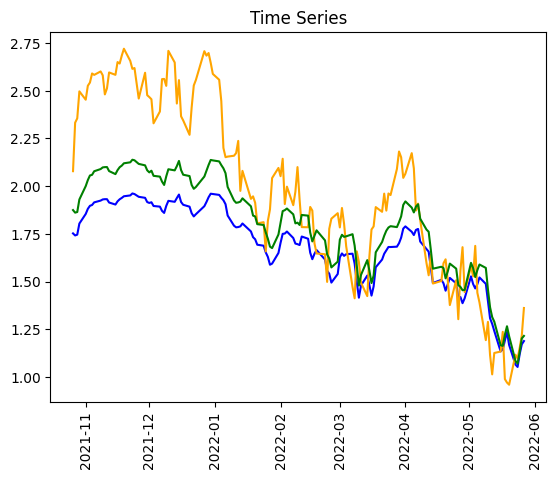

In [62]:
x_vals=y_test_timestamps
GRU_vals=y_pred
LSTM_vals=LSTM_pred
plt.plot(x_vals,GRU_vals,color='blue')
plt.plot(x_vals,y_test,color='orange')
plt.plot(x_vals,LSTM_pred,color='green')
plt.xticks(rotation=90)
plt.title('Time Series')